## DQN Algorithm
- Initialize policy network weights
- Copy policy network, and call it target network
- Initialize replay memory
- For each Episode:
- - Initialize starting state
  - for each time step:
  - - select an action via explore/explit
    - excute the selected action via gym
    - get reward and next state
    - store experience in replay memory
    - sample random batch from replay memory
    - Preprocess states from batch
    - Pass batch of preprocessed states to policy network
    - Calculate loss between output Q values and target Q values
    - Gradeint descent updates weights to minimize loss

In [1]:
import gymnasium as gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [2]:
from collections import namedtuple
from itertools import count

In [3]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython: from IPython import display

In [4]:
class DQN(nn.Module):
    def __init__(self, img_height, img_width):
        super().__init__()
        self.fc1 = nn.Linear(in_features=img_height*img_width*3,out_features=24)
        self.fc2 = nn.Linear(in_features=24, out_features=32)
        self.out = nn.Linear(in_features=32, out_features=2)

    def forward(self, t):
        t = t.flatten(start_dim=1)
        t = F.relu(self.fc1(t))
        t = F.relu(self.fc2(t))
        t = self.out(t)
        return t


In [5]:
Experience = namedtuple(
    'Experience',
    ('state', 'action', 'next_state', 'reward')
)
e = Experience(1,2,3,4)
e

Experience(state=1, action=2, next_state=3, reward=4)

In [6]:
class ReplayMemory():
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.count = 0

    def push(self, exp):
        if len(self.memory) < self.capacity:
            self.memory.append(exp)
        else:
            self.memory[self.count % self.capacity] = exp
            self.count += 1

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def can_provide_sample(self, batch_size):
        return len(self.memory) >= batch_size

In [7]:
class EpsilonGreedyStrategy():
    def __init__(self, start, end, decay):
        self.start = start
        self.end = end
        self.decay = decay

    def get_exploration_rate(self, step):
        return self.end + (self.start - self.end) * math.exp(-1. * step * self.decay)

In [8]:
class Agent():
    def __init__(self, strategy, num_actions, device):
        self.step = 0
        self.strategy = strategy
        self.num_actions = num_actions
        self.device = device

    def select_action(self, state, policy_net):
        rate = self.strategy.get_exploration_rate(self.step)
        self.step += 1
        if rate > random.random():
            action = random.randrange(self.num_actions)
            return torch.tensor([action]).to(self.device)
        else:
            with torch.no_grad():
                return policy_net(state).argmax(dim=1).to(self.device)

In [9]:
class EnvManager():
    def __init__(self, device):
        self.device = device
        self.env = gym.make('CartPole-v0').unwrapped
        self.env.reset()
        self.current_screen = None
        self.done = False

    def reset(self):
        self.env.reset()
        self.current_screen = None

    def close(self):
        self.env.close()

    def render(self, mode='human'):
        self.env.render_mode=mode
        return self.env.render()

    def num_actions_available(self):
        return self.env.action_space.n

    def take_action(self, action):
        _, reward, self.done, _, _ = self.env.step(action.item())
        return torch.tensor([reward], device=self.device)

    def just_starting(self):
        return self.current_screen is None

    def get_state(self):
        if self.just_starting() or self.done:
            self.current_screen = self.get_processed_screen()
            black_screen = torch.zeros_like(self.current_screen)
            return black_screen
        else:
            s1 = self.current_screen
            s2 = self.get_processed_screen()
            self.current_screen = s2
            return s2 - s1

    def get_screen_height(self):
        screen = self.get_processed_screen()
        return screen.shape[2]

    def get_screen_width(self):
        screen = self.get_processed_screen()
        return screen.shape[3]
    
    def get_processed_screen(self):
        screen = self.render('rgb_array').transpose((2,0,1))
        screen = self.crop_screen(screen)
        return self.transform_screen(screen)

    def crop_screen(self, screen):
        screen_height = screen.shape[1]
        top = int(screen_height * 0.4)
        bottom = int(screen_height * 0.8)
        screen = screen[:,top:bottom,:]
        return screen

    def transform_screen(self, screen):
        screen = np.ascontiguousarray(screen, np.float32)/255
        screen = torch.from_numpy(screen)

        resize = T.Compose([
            T.ToPILImage(),
            T.Resize((40,90)),
            T.ToTensor()
        ])
        return resize(screen).unsqueeze(0).to(self.device)

In [10]:
def get_moving_avg(values, period):
    values = torch.tensor(values, dtype=torch.float)
    if len(values) >= period:
        moving_avg = values.unfold(dimension=0, size=period, step=1).mean(dim=1).flatten(start_dim=0)
        moving_avg = torch.cat((torch.zeros(period-1), moving_avg))
        return moving_avg.numpy()
    else:
        moving_avg = torch.zeros(len(values))
        return moving_avg.numpy()

In [11]:
get_moving_avg(np.random.rand(10), 3)

array([0.        , 0.        , 0.35433698, 0.5512339 , 0.5502344 ,
       0.6450683 , 0.744199  , 0.6039443 , 0.7673564 , 0.51678073],
      dtype=float32)

In [12]:
def plot(values, moving_avg_period):
    plt.figure(2)
    plt.clf()
    plt.xlabel('Episodes')
    plt.ylabel('Duration')
    plt.plot(values)
    moving_avg = get_moving_avg(values, moving_avg_period)
    plt.plot(moving_avg)
    plt.pause(0.001)

    print("Episode", len(values), '\n', moving_avg_period, 'episode moving avg:', moving_avg[-1])
    if is_ipython: display.clear_output(wait=True)

In [13]:
batch_size = 256
gamma = 0.999
epsilon_start = 1
epsilon_end = 0.01
epsilon_decay = 0.001
target_update = 10
memory_size = 100000
lr = 0.001
num_episodes = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
em = EnvManager(device)
strategy = EpsilonGreedyStrategy(epsilon_start, epsilon_end, epsilon_decay)
agent = Agent(strategy, em.num_actions_available(), device)
memory = ReplayMemory(memory_size)
policy_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)
target_net = DQN(em.get_screen_height(), em.get_screen_width()).to(device)

/Users/richardhall/Dev/ai/rl_and_deep_rl_python/.env/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [15]:
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

DQN(
  (fc1): Linear(in_features=10800, out_features=24, bias=True)
  (fc2): Linear(in_features=24, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=2, bias=True)
)

In [16]:
optimizer = optim.Adam(params = policy_net.parameters(), lr=lr)

In [17]:
def extract_tensors(experiences):
    batch = Experience(*zip(*experiences))

    t1 = torch.cat(batch.state)
    t2 = torch.cat(batch.action)
    t3 = torch.cat(batch.reward)
    t4 = torch.cat(batch.next_state)

    return (t1, t2, t3, t4)

In [18]:
class QValues():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    @staticmethod
    def get_current(policy_net, states, actions):
        return policy_net(states).gather(dim=1, index=actions.unsqueeze(-1))

    @staticmethod
    def get_next(target_net, next_states):
        final_state_locations = next_states.flatten(start_dim=1).max(dim=1)[0].eq(0).type(torch.bool)
        non_final_state_locations = (final_state_locations == False)

        non_final_states = next_states[non_final_state_locations]
        batch_size = next_states.shape[0]
        values = torch.zeros(batch_size).to(QValues.device)
        values[non_final_state_locations] = target_net(non_final_states).max(dim=1)[0].detach()

        return values
    

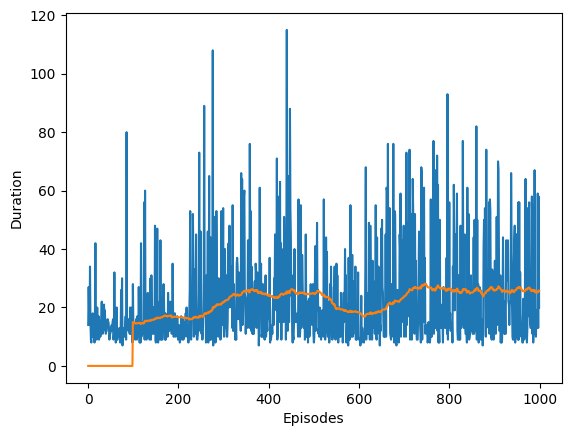

Episode 1000 
 100 episode moving avg: 25.73


In [19]:
episode_duration = []
for episode in range(num_episodes):
    em.reset()
    state = em.get_state()
    for timestep in count():
        action = agent.select_action(state, policy_net)
        reward = em.take_action(action)
        next_state = em.get_state()

        memory.push(Experience(state, action, next_state, reward))
        state = next_state

        if memory.can_provide_sample(batch_size):
            experiences = memory.sample(batch_size)
            states, actions, rewards, next_states = extract_tensors(experiences)

            current_q_values = QValues.get_current(policy_net, states, actions)
            next_q_values = QValues.get_next(target_net, next_states)
            target_q_values = (next_q_values * gamma) + rewards

            loss = F.mse_loss(current_q_values, target_q_values.unsqueeze(1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if em.done:
            episode_duration.append(timestep)
            plot(episode_duration, 100)
            break

    if episode % target_update == 0:
        target_net.load_state_dict(policy_net.state_dict())

em.close()

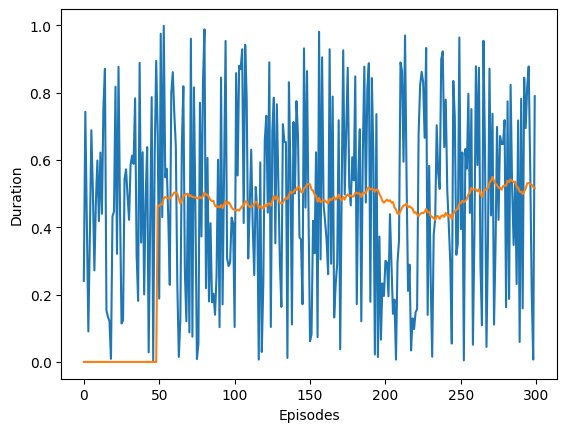

Episode 300 
 50 episode moving avg: 0.51590586


In [20]:
plot(np.random.rand(300), 50)

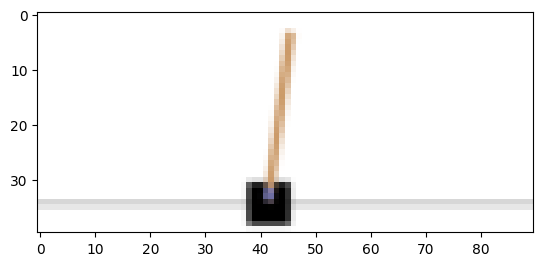

In [21]:
# processed screen
screen = em.get_processed_screen()

plt.figure()
plt.imshow(screen.squeeze(0).permute(1,2,0).cpu(), interpolation=None)
plt.show()

/Users/richardhall/Dev/ai/rl_and_deep_rl_python/.env/lib/python3.10/site-packages/gymnasium/envs/registration.py:513: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


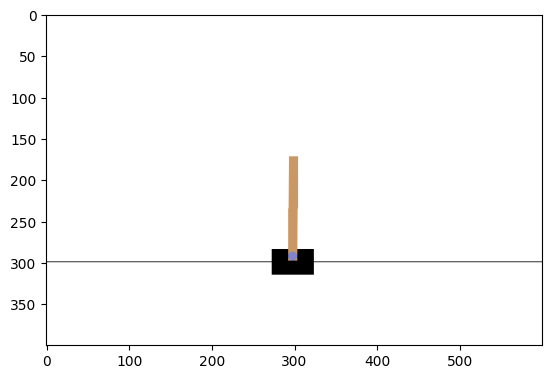

In [22]:
# non processed screen

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
em = EnvManager(device)
em.reset()
screen = em.render('rgb_array')

plt.figure()
plt.imshow(screen)
plt.show()